In [4]:
# Dataset Courtesy : Nidia Sahjara

import pandas as pd
import numpy as np
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
!pip install gensim
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings(action = "ignore", category = UserWarning, module = "gensim")
warnings.filterwarnings(action = "ignore", category = FutureWarning, module = "gensim")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data = pd.read_csv(r"/content/drive/MyDrive/netflix_titles.csv")

In [7]:
data.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

Extracting only the columns that we need:

In [8]:
df = data[["title", "description", "listed_in"]]

In [9]:
df.head()

,title,description,listed_in
0,Norm of the North: King Sized Adventure,Before planning an awesome wedding for his gra...,"Children & Family Movies, Comedies"
1,Jandino: Whatever it Takes,Jandino Asporaat riffs on the challenges of ra...,Stand-Up Comedy
2,Transformers Prime,"With the help of three human allies, the Autob...",Kids' TV
3,Transformers: Robots in Disguise,When a prison ship crash unleashes hundreds of...,Kids' TV
4,#realityhigh,When nerdy high schooler Dani finally attracts...,Comedies


In [12]:
df.isnull().sum()

title          0
description    0
listed_in      0
dtype: int64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


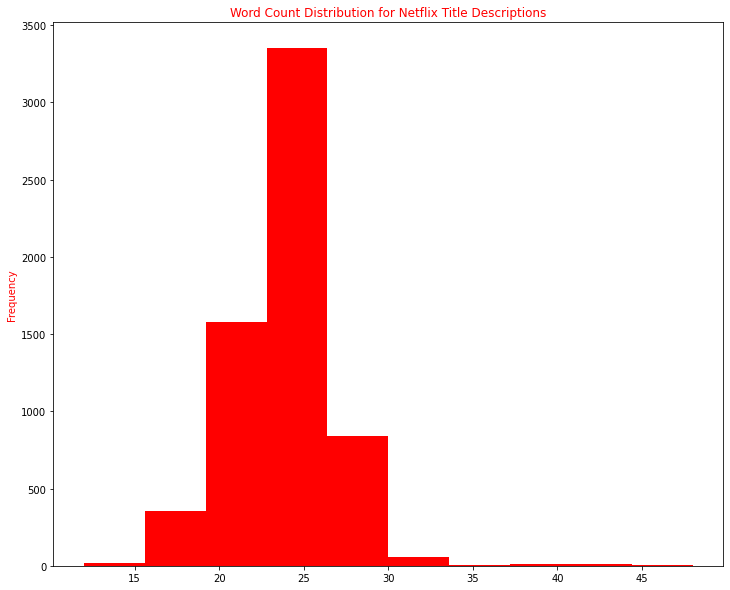

In [15]:
df["word count"] = df.description.apply(lambda x: len(str(x).split()))
ax = df["word count"].plot(
    kind = "hist",
    bins = 10,
    color = "red",
    figsize = (12, 10),
    title = "Word Count Distribution for Netflix Title Descriptions"
)

ax.title.set_color("Red")
ax.yaxis.label.set_color("Red")
ax.xaxis.label.set_color("Red")

In [43]:
# -----Preprocessing-----

# remove non - ascii 

def remove_ascii(str):
  output = "".join(i for i in str if ord(i) < 128)
  return output.lower()

def lowercase(str):
  return str.lower()

def remove_stopwords(str):
  x = str.split()
  stops = set(stopwords.words("english"))
  text = [word for word in x if not word in stops]
  output = " ".join(text)
  return output

def clean_html(str):
  html = re.compile("<.*?>")
  return html.sub(r"", str)

def punc(str):
  token = RegexpTokenizer(r"\w+")
  text = token.tokenize(str)
  output = " ".join(text)
  return output

In [44]:
df["clean description"] = df.description.apply(func = remove_ascii)
df["clean description"] = df["clean description"].apply(func = lowercase)
df["clean description"] = df["clean description"].apply(func = remove_stopwords)
df["clean description"] = df["clean description"].apply(func = clean_html)
df["clean description"] = df["clean description"].apply(func = punc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [45]:
df.head()

,title,description,listed_in,word count,clean description
0,Norm of the North: King Sized Adventure,Before planning an awesome wedding for his gra...,"Children & Family Movies, Comedies",23,planning awesome wedding grandfather polar bea...
1,Jandino: Whatever it Takes,Jandino Asporaat riffs on the challenges of ra...,Stand-Up Comedy,25,jandino asporaat riffs challenges raising kids...
2,Transformers Prime,"With the help of three human allies, the Autob...",Kids' TV,23,help three human allies autobots protect earth...
3,Transformers: Robots in Disguise,When a prison ship crash unleashes hundreds of...,Kids' TV,20,prison ship crash unleashes hundreds deceptico...
4,#realityhigh,When nerdy high schooler Dani finally attracts...,Comedies,26,nerdy high schooler dani finally attracts inte...


In [46]:
# Word2Vec

corpus = []

for words in df["clean description"]:
  corpus.append(words.split())

In [47]:
len(corpus)

6234

In [55]:
# Transfer Learning using the pre-trained Google News Model (GoogleNews-vectors-negative300) with the gensim lib

!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"


--2022-01-17 06:03:45--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.139.144
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.139.144|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [56]:
EMBEDDING_FILE = "/root/input/GoogleNews-vectors-negative300.bin.gz"

training corpus with Google pretrained model

In [63]:
pretrained_model = Word2Vec(size = 300, window = 5, min_count = 2, workers = -1)
pretrained_model.build_vocab(corpus)
pretrained_model.intersect_word2vec_format(EMBEDDING_FILE, lockf = 1.0, binary = True)
pretrained_model.train(corpus, total_examples = pretrained_model.corpus_count, epochs = 5)

(0, 0)

In [64]:
type(pretrained_model)

gensim.models.word2vec.Word2Vec

In [76]:
# test
pretrained_model.wv.most_similar(positive = ["india"]) # the positive parameter gives a list of keys that contribute positively

[('indian', 0.6967039704322815),
 ('pakistan', 0.6815168261528015),
 ('chennai', 0.6675503849983215),
 ('america', 0.6589398980140686),
 ('canada', 0.6490967869758606),
 ('australia', 0.6368584036827087),
 ('mexico', 0.6239137649536133),
 ('uk', 0.6221641898155212),
 ('kerala', 0.6117700934410095),
 ('malaysia', 0.6090297698974609)]

In [80]:
# test 2
pretrained_model.wv.similarity("king", "prince")

0.61599934

In [81]:
# test 3
pretrained_model.wv.similarity("king", "leg")

0.07946689

In [105]:
# function to define average word2vec for each netflix description

def vectorizer(x):

  global embeddings
  embeddings = [] # list to store all the vectors / vectorized netflix descriptions
  for line in df["clean description"]:
    count = 0
    w2v = NoneCount = 0
    for word in line.split():
      if word in pretrained_model.wv.vocab:
        count += 1
        if w2v is None:
          w2v = pretrained_model.wv[word]
        else:
          w2v += pretrained_model.wv[word]
    
    if w2v is not None:
      w2v = w2v / count
      embeddings.append(w2v)

In [106]:
# function to gt most similar shows

def most_similar(title):
  vectorizer(df)
  cos_sim = cosine_similarity(embeddings, embeddings)
  netflix_shows = df[["title"]] # a new data frame with reversed indexes
  indices = pd.Series(df.index, index = df["title"]).drop_duplicates()
  ix = indices[title]
  cos_sim_ = list(enumerate(cos_sim[ix]))
  cos_sim_ = sorted(cos_sim_, key = lambda x: x[1], reverse = True)
  cos_sim_ = cos_sim_[1:6] # top 5 similar shows
  netflix_index = [i[0] for i in cos_sim_]
  watch_next = netflix_shows.iloc[netflix_index]
  for index, row in watch_next.iterrows():
    print(row["title"])



In [126]:
most_similar("Narcos")

Narcos: Mexico
El Chapo
Saaho
Pablo Escobar, el patrón del mal
Paid in Full
